In [1]:
import pandas as pd
import geopandas as gpd
#import seaborn as sbn
import sodapy
#import plotly.offline as plt
import matplotlib
import matplotlib.pyplot as plt
import json
import datetime

# Creem un dataframe amb el codi del municipi i el nombre d'habitants

In [2]:
pob = pd.read_csv("data/poblacio_per_municipis.csv", encoding='latin1', header=3, sep=";")
pob.columns

Index(['Any', 'Codi', 'Municipi', 'Edats', 'Homes', 'Dones', 'Total'], dtype='object')

In [3]:
total_pob = pob[pob['Edats']==' Total'].copy()
total_pob['Total'] = total_pob['Total'].str.replace(".","")
total_pob['Habitants'] = total_pob['Total'].astype(int)
total_pob['Codi'] = total_pob['Codi'].str[:-1]
total_pob['Codi'] = total_pob['Codi'].astype(int)
total_pob = total_pob[['Codi','Habitants']]
print(total_pob)

        Codi  Habitants
101    25001        179
203     8001      12489
305    25002        588
407    25003       5371
509     8002        288
...      ...        ...
96185  25255        470
96287  43177        428
96389  43178       2056
96491   8308        168
96593  43052       1170

[947 rows x 2 columns]


# Carreguem el mapa de Municipis

In [4]:
geodf = gpd.read_file('maps/Municipios.shp')
print(geodf.columns)
geodf['Codigo']=geodf['Codigo'].astype(int)
print(geodf['Codigo'])


Index(['Codigo', 'Texto', 'Cod_Prov', 'Provincia', 'Cod_CCAA', 'ComAutonom',
       'geometry'],
      dtype='object')
0       8001
1       8002
2       8003
3       8004
4       8005
       ...  
941    43902
942    43903
943    43904
944    43905
945    43906
Name: Codigo, Length: 946, dtype: int64


# i li afegim l'atribut del nombre d'habitants

In [5]:
geodf.drop(columns=['Habitants'], inplace=True, errors='ignore')
geodf = geodf.join(total_pob.set_index('Codi'), on='Codigo')

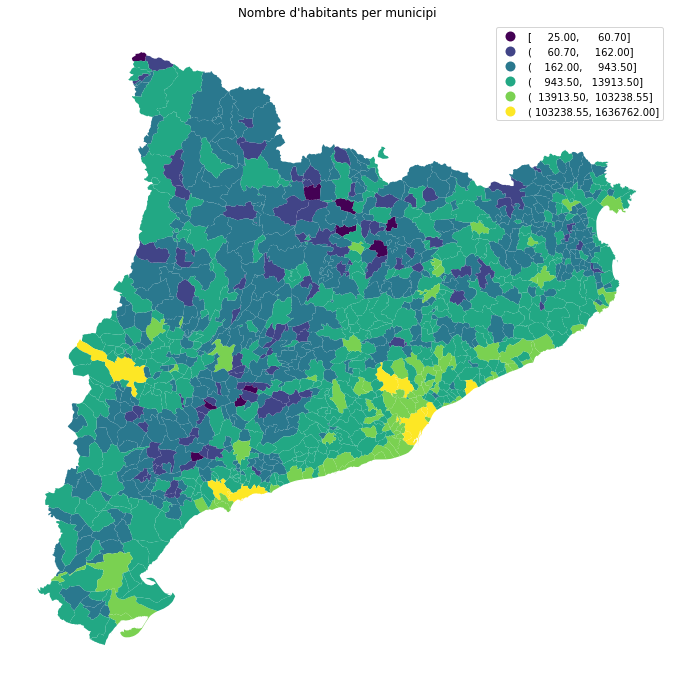

In [6]:
f, ax = plt.subplots(1, figsize=(12, 12))
geodf.plot(ax=ax, column='Habitants', legend=True, scheme="percentiles")
ax.set_axis_off()
ax.set_title("Nombre d'habitants per municipi")
pass

# Ara utilitzem sodapy per accedir a les dades obertes Covid publicades per la Generalitat

In [7]:
last_day = datetime.date.today() - datetime.timedelta(days=3)
#first_day = last_day - datetime.timedelta(days=21)
fourteen_ago = last_day - datetime.timedelta(days=13)
seven_ago = last_day - datetime.timedelta(days=6)
#print(first_day)

In [8]:
def load_covid(since):
    print("Loading Covid data since "+str(since)+" (inclusive)")
    with sodapy.Socrata("analisi.transparenciacatalunya.cat", None) as client:
        #count = 0
        data = []
        for item in client.get_all("jj6z-iyrp", where="data >= '"+str(since)+"'"):
            #count +=1
            data.append(item)
        #print(count)
    df_cases = pd.DataFrame(data)
    df_cases['data'] = pd.to_datetime(df_cases['data'])
    df_cases['numcasos'] = df_cases['numcasos'].astype(int)
    df_cases['municipicodi'] = df_cases['municipicodi'].astype(float)
    df_cases['municipicodi'] = df_cases['municipicodi'].fillna(0)
    df_cases['municipicodi'] = df_cases['municipicodi'].astype(int)
    return df_cases


In [9]:
df_cases = load_covid(since=fourteen_ago)
df_cases

Loading Covid data since 2020-08-18 (inclusive)


,data,comarcacodi,comarcadescripcio,municipicodi,municipidescripcio,sexecodi,sexedescripcio,resultatcoviddescripcio,numcasos
0,2020-08-18,11,Baix Llobregat,8056,Castelldefels,0,Home,Sospitós,63
1,2020-08-18,22,Montsià,43014,Amposta,1,Dona,Sospitós,8
2,2020-08-18,40,Vallès Occidental,8184,Rubí,1,Dona,Sospitós,43
3,2020-08-18,11,Baix Llobregat,8169,El Prat de Llobregat,1,Dona,Sospitós,39
4,2020-08-18,11,Baix Llobregat,8073,Cornellà de Llobregat,1,Dona,Sospitós,63
...,...,...,...,...,...,...,...,...,...
15863,2020-09-02,02,Alt Empordà,17030,Cabanes,1,Dona,Sospitós,1
15864,2020-09-02,34,Selva,17180,Santa Coloma de Farners,1,Dona,Sospitós,3
15865,2020-09-02,02,Alt Empordà,17066,Figueres,1,Dona,Sospitós,6
15866,2020-09-02,22,Montsià,43156,Ulldecona,1,Dona,Sospitós,1


In [10]:
print(df_cases['resultatcoviddescripcio'].unique())
#print(df_cases['municipicodi'].unique())


['Sospitós' 'Positiu PCR' 'Positiu per ELISA' 'Epidemiològic'
 'Positiu per Test Ràpid']


# Calculem el nombre de casos per municipi 

In [11]:
# Compute average cases in the period [start-end] with both days included.

def average_cases_period(data, start, end):
    cases_by_municipi = {}
    for _,entry in data.iterrows():
        if (entry['data'] >= start) and (entry['data'] <= end):
            #if ('municipicodi' in entry) and \
            if (entry['resultatcoviddescripcio']!='Sospitós') and\
                (entry['resultatcoviddescripcio']!='Positiu per Test Ràpid'): #and \
                #(type(entry['municipicodi'])==str):
                #print(entry['resultatcoviddescripcio'])
                #print(entry['municipicodi'])
                #print(entry['data'])
                if entry['municipicodi'] in cases_by_municipi:
                    cases_by_municipi[entry['municipicodi']] += entry['numcasos']
                else:
                    cases_by_municipi[entry['municipicodi']] = entry['numcasos']
    #print(cases_by_municipi)
    cases_df = pd.DataFrame(cases_by_municipi.items(), columns=["Codi","Cases"])
    cases_df['Codi'] = cases_df['Codi'].astype(int)
    cases_df['Cases'] = cases_df['Cases'].astype(float)
    #print("Days:"+str((end-start).days))
    cases_df['AverageCases'] = cases_df['Cases']/((end-start).days + 1)
    return cases_df


# i fem els plots

In [22]:
def make_plot_schools(geodf, df_cases, start, end):
    average_cases = average_cases_period(df_cases, start, end)
    mygeodf = geodf.copy()
    #drop(columns=["Cases",'AverageCases'], errors='ignore')
    mygeodf = mygeodf.join(average_cases.set_index('Codi'), on='Codigo')
    mygeodf['DailyIncidence'] = 100000*(mygeodf['AverageCases']/mygeodf['Habitants'])
    mygeodf['DailyIncidence'] = mygeodf['DailyIncidence'].fillna(0.0001)
    #geodf.plot(column='DailyIncidence', legend=True)
    mygeodf['DDailyIncidence'] = pd.cut(mygeodf['DailyIncidence'], bins=[0,1,10,25,1000])
    #geodf['DDailyIncidence'] = geodf['DDailyIncidence'].fillna(0)
    
    f, ax = plt.subplots(1, figsize=(12, 12))
    mygeodf.plot(ax=ax, column='DDailyIncidence', linewidth=0.5, edgecolor='0.5', legend=True, legend_kwds={'loc': 'lower right','title':"Casos diaris per 100,000 persones"}, cmap=matplotlib.colors.ListedColormap(["green","yellow","orange","red"]))
    ax.set_axis_off()
    ax.set_title("Municipis que haurien d'endarrerir l'obertura d'escoles (en vermell) basat en \n"
                 "la mitjana de casos diaria per 100.000 habitants en el període entre " + str(start) + " i " + str(end))

    plt.axis('equal')
    f.patch.set_facecolor('whitesmoke')
    plt.savefig("figs/Schools"+str(start)+"-"+str(end)+".png", transparent=False)
    plt.show()   
    


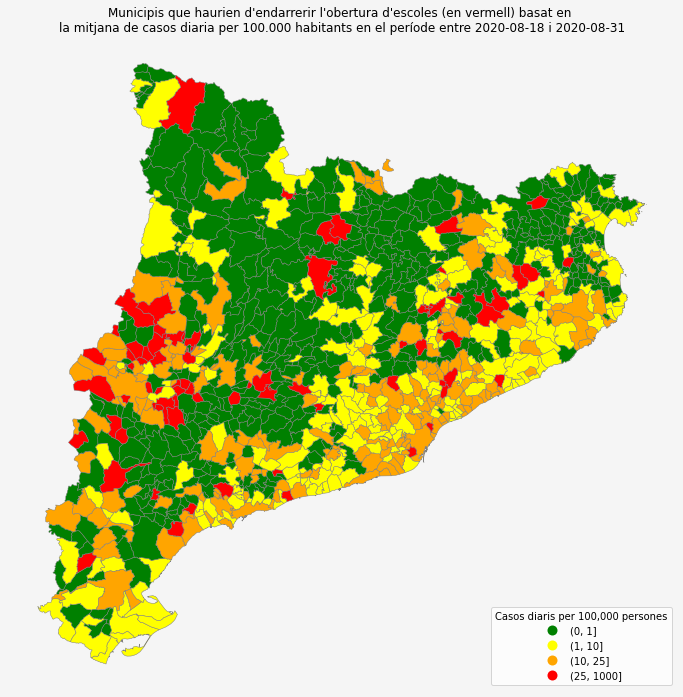

In [23]:
make_plot_schools(geodf, df_cases, fourteen_ago, last_day)

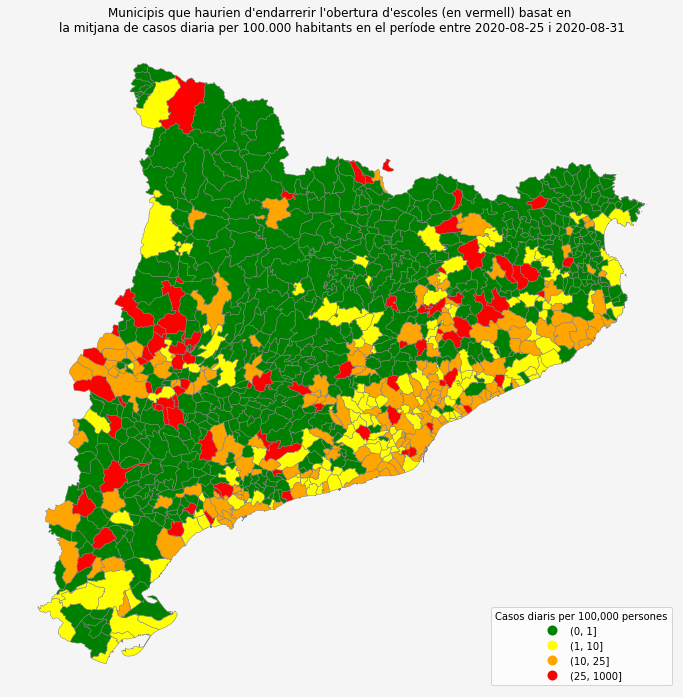

In [24]:
make_plot_schools(geodf, df_cases, seven_ago, last_day)